# Initial Set up

In [ ]:
cd C:\Users\ishaa\Desktop\OK\ML

C:\Users\ishaa\Desktop\OK\ML


C:\Users\ishaa\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
import tensorflow as tf
import os

# Clear any existing sessions
tf.keras.backend.clear_session()

# Disable any environment variables that might interfere
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TF_VISIBLE_DEVICES"] = ""

# Enable device placement logging (optional, for debugging)
# tf.debugging.set_log_device_placement(True)

# List all physical GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Check visible devices
print("Visible devices:", tf.config.get_visible_devices('GPU'))


Available GPUs: []
Visible devices: []


In [ ]:
import tensorflow as tf
print("Devices before model:", tf.config.get_visible_devices('GPU'))

# Create and train a small dummy model to check GPU utilization
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation='relu', input_shape=(10,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy')

# Dummy data
X_train = np.random.randn(1000, 10)
y_train = np.random.randint(0, 2, size=(1000,))

# Train for a few epochs
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

print("Devices after model:", tf.config.get_visible_devices('GPU'))


Devices before model: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Epoch 1/5
32/32 [==============================] - 0s 3ms/step - loss: 0.7051
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 0.6898
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 0.6849
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 0.6797
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 0.6741
Devices after model: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Data collection step

Fetching sequences for SARS-CoV-2...
Fetching sequences for Dengue...
Fetching sequences for Zika...
Fetching sequences for HPV...

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   accession_id   400 non-null    object
 1   sequence       400 non-null    object
 2   species        400 non-null    object
 3   length         400 non-null    int64 
 4   invalid_chars  400 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.8+ KB
None

Class Distribution:
species
SARS-CoV-2    100
Dengue        100
Zika          100
HPV           100
Name: count, dtype: int64

Sample Sequence:
AAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTA

Sequence Length Statistics:
count      400.000000
mean     14531.410000
std       8865.576778
min       7053.000000
25%       9702.500000
50%     

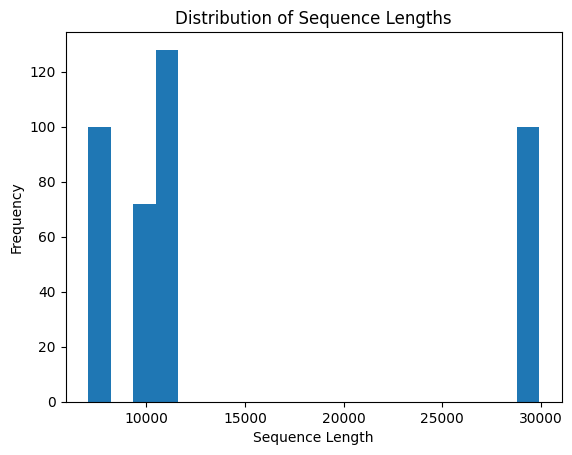


Nucleotide Composition Statistics:
                 A            C            G            T        Other
count   400.000000   400.000000   400.000000   400.000000   400.000000
mean   4358.825000  2778.520000  3261.535000  4047.135000    85.395000
std    2622.850836  1569.301514  1575.121254  3175.943539   372.176595
min    2066.000000  1147.000000  1198.000000  1607.000000     0.000000
25%    2461.000000  1617.250000  2113.250000  2199.000000     0.000000
50%    3061.500000  2221.000000  2793.000000  2277.000000     0.000000
75%    4585.250000  2953.750000  3592.250000  3885.000000    12.500000
max    8950.000000  5480.000000  5867.000000  9606.000000  4465.000000


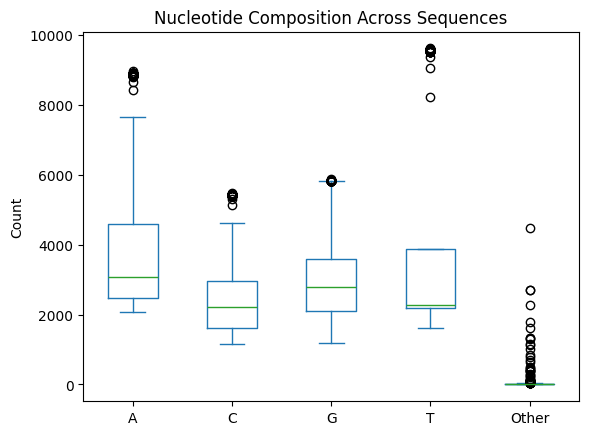


Number of U's in sequences: 0

Sequences with Invalid Characters:
    accession_id invalid_chars
46    PV448335.1        {Y, K}
68    PV442986.1           {Y}
123   LC793496.1     {S, R, K}
124   LC793495.1        {Y, R}
125   LC793494.1           {Y}
132   PP582679.1        {Y, K}
151   PP582655.1           {Y}
161   PP582627.1           {R}
185   PP968117.1     {Y, R, K}
190   PP711274.1           {R}
Preprocessed dataset saved as 'virus_sequences_preprocessed_no_influenza_scaled.csv'


In [ ]:
from Bio import Entrez, SeqIO
import pandas as pd
import matplotlib.pyplot as plt

Entrez.email = "is.ishaansammeta@gmail.com"
# Entrez.api_key = "your_api_key"  # Uncomment and add your API key if you have one

virus_species = {
    "SARS-CoV-2": "SARS-CoV-2[Organism] AND complete genome",
    "Dengue": "Dengue virus[Organism] AND complete genome",
    "Zika": "Zika virus[Organism] AND complete genome",
    "HPV": "Human papillomavirus[Organism] AND complete genome"
}

sequences = []
labels = []
accession_ids = []

for species, query in virus_species.items():
    print(f"Fetching sequences for {species}...")
    try:
        handle = Entrez.esearch(db="nucleotide", term=query, retmax=100)
        record = Entrez.read(handle)
        handle.close()

        if len(record["IdList"]) < 100:
            print(f"Warning: Only {len(record['IdList'])} sequences found for {species}")

        # Batch fetch sequences (e.g., 50 at a time)
        id_list = record["IdList"]
        batch_size = 50
        for start in range(0, len(id_list), batch_size):
            batch_ids = id_list[start:start + batch_size]
            print(f"Downloading batch {start//batch_size + 1} for {species}...")
            try:
                handle = Entrez.efetch(db="nucleotide", id=",".join(batch_ids), rettype="fasta", retmode="text")
                seq_records = list(SeqIO.parse(handle, "fasta"))
                handle.close()
                for seq_record in seq_records:
                    sequences.append(str(seq_record.seq))
                    labels.append(species)
                    accession_ids.append(seq_record.id)
            except Exception as e:
                print(f"Error downloading batch {start//batch_size + 1} for {species}: {e}")
    except Exception as e:
        print(f"Error searching for {species}: {e}")

# Create a DataFrame
data = pd.DataFrame({
    "accession_id": accession_ids,
    "sequence": sequences,
    "species": labels
})

# Preprocessing steps
data["sequence"] = data["sequence"].str.replace("U", "T")
data["length"] = data["sequence"].apply(len)
valid_nucleotides = set("ACGTN")
data["invalid_chars"] = data["sequence"].apply(lambda x: set(x) - valid_nucleotides)

# Display the dataset
print("\nDataset Info:")
print(data.info())
print("\nClass Distribution:")
print(data["species"].value_counts())
print("\nSample Sequence:")
print(data.iloc[0]["sequence"][:100])

# Sequence length statistics
print("\nSequence Length Statistics:")
print(data["length"].describe())
plt.hist(data["length"], bins=20)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Sequence Lengths")
plt.show()

# Nucleotide composition
def count_nucleotides(sequence):
    return {
        "A": sequence.count("A"),
        "C": sequence.count("C"),
        "G": sequence.count("G"),
        "T": sequence.count("T"),
        "Other": len(sequence) - (sequence.count("A") + sequence.count("C") + sequence.count("G") + sequence.count("T"))
    }

nucleotide_counts = data["sequence"].apply(count_nucleotides).apply(pd.Series)
print("\nNucleotide Composition Statistics:")
print(nucleotide_counts.describe())
nucleotide_counts.plot(kind="box")
plt.title("Nucleotide Composition Across Sequences")
plt.ylabel("Count")
plt.show()

print("\nNumber of U's in sequences:", data["sequence"].str.count("U").sum())
print("\nSequences with Invalid Characters:")
print(data[data["invalid_chars"].apply(len) > 0][["accession_id", "invalid_chars"]])

data.to_csv("virus_sequences_preprocessed_no_influenza_scaled.csv", index=False)
print("Preprocessed dataset saved as 'virus_sequences_preprocessed_no_influenza_scaled.csv'")

In [ ]:
import os
import pandas as pd
from Bio import Entrez, SeqIO
import time
from tqdm import tqdm

# Set your NCBI email (required for Entrez)
Entrez.email = "your.email@example.com"  # Replace with your email

# Existing dataset file
existing_data_file = "virus_sequences_preprocessed_no_influenza_scaled.csv"
intermediate_file = "virus_sequences_preprocessed_with_influenza.csv"
output_file = "virus_sequences_preprocessed_with_influenza_cleaned.csv"

# Function to convert U to T in sequences
def convert_u_to_t(sequence):
    return sequence.replace("U", "T")

# Function to check for invalid characters
def has_invalid_chars(sequence):
    valid_nucleotides = set("ACGTN")
    return set(sequence) - valid_nucleotides

# Function to replace invalid characters with 'N'
def replace_invalid_chars(sequence):
    invalid_chars = set("YKWRSM")  # Ambiguous nucleotides to replace
    return ''.join('N' if char in invalid_chars else char for char in sequence)

# Fetch Influenza A sequences from NCBI
def fetch_influenza_sequences(num_strains=100):
    influenza_sequences = []
    segment_names = ["PB2", "PB1", "PA", "HA", "NP", "NA", "M", "NS"]

    # Search for Influenza A complete genome sequences
    search_term = "Influenza A[Organism] AND complete genome[Title]"
    handle = Entrez.esearch(db="nucleotide", term=search_term, retmax=1000)
    record = Entrez.read(handle)
    handle.close()

    # Randomly select 100 unique strain IDs (adjust based on availability)
    strain_ids = record["IdList"]
    if len(strain_ids) < num_strains:
        print(f"Warning: Only {len(strain_ids)} strains found. Using all available.")
    strain_ids = strain_ids[:num_strains]

    for strain_id in tqdm(strain_ids, desc="Fetching Influenza A strains"):
        try:
            # Fetch sequence data for the strain
            handle = Entrez.efetch(db="nucleotide", id=strain_id, rettype="gb", retmode="text")
            record = SeqIO.read(handle, "genbank")
            handle.close()

            # Extract all segments (assuming segments are annotated in features)
            segments = {seg.qualifiers.get("segment")[0]: str(seg.seq) for seg in record.features
                       if seg.type == "source" and "segment" in seg.qualifiers}

            # Check if all 8 segments are present
            if len(segments) == 8 and all(seg in segments for seg in segment_names):
                # Concatenate all segments after U-to-T conversion
                concatenated_seq = "".join(convert_u_to_t(segments[seg]) for seg in segment_names)

                # Validate sequence
                if not has_invalid_chars(concatenated_seq):
                    sequence_length = len(concatenated_seq)
                    influenza_sequences.append({
                        "accession_id": f"strain_{strain_id}_concatenated",
                        "sequence": concatenated_seq,
                        "species": "Influenza",
                        "length": sequence_length
                    })
                else:
                    print(f"Skipping strain {strain_id}: Invalid characters detected.")
            else:
                print(f"Skipping strain {strain_id}: Incomplete segments (missing {8 - len(segments)}).")

            time.sleep(0.1)  # Respect NCBI usage guidelines
        except Exception as e:
            print(f"Error processing strain {strain_id}: {e}")
            continue

    return influenza_sequences

# Load existing dataset
if os.path.exists(existing_data_file):
    existing_df = pd.read_csv(existing_data_file)
else:
    raise FileNotFoundError(f"{existing_data_file} not found. Please ensure it exists.")

# Fetch new Influenza sequences
print("Fetching Influenza A sequences from NCBI...")
influenza_data = fetch_influenza_sequences(num_strains=100)

# Convert to DataFrame and append to existing dataset
influenza_df = pd.DataFrame(influenza_data)
combined_df = pd.concat([existing_df, influenza_df], ignore_index=True)

# Initial preprocessing: U-to-T conversion and length calculation
combined_df["sequence"] = combined_df["sequence"].str.replace("U", "T")
combined_df["length"] = combined_df["sequence"].apply(len)
combined_df["invalid_chars"] = combined_df["sequence"].apply(has_invalid_chars)

# Display initial dataset info
print("\nInitial Updated Dataset Info:")
print(combined_df.info())
print("\nInitial Class Distribution:")
print(combined_df["species"].value_counts())
print("\nInitial Sequence Length Statistics:")
print(combined_df["length"].describe())

# Check for invalid characters
print("\nInitial Sequences with Invalid Characters:")
print(combined_df[combined_df["invalid_chars"].apply(len) > 0][["accession_id", "invalid_chars"]])

# Save intermediate dataset
combined_df.to_csv(intermediate_file, index=False)
print(f"Intermediate dataset saved as {intermediate_file}")

# Further cleaning: Replace invalid characters with 'N'
combined_df["sequence"] = combined_df["sequence"].apply(replace_invalid_chars)
combined_df["invalid_chars"] = combined_df["sequence"].apply(has_invalid_chars)

# Display cleaned dataset info
print("\nCleaned Dataset Info:")
print(combined_df.info())
print("\nCleaned Class Distribution:")
print(combined_df["species"].value_counts())
print("\nCleaned Sequence Length Statistics:")
print(combined_df["length"].describe())

# Check for invalid characters after cleaning
print("\nCleaned Sequences with Invalid Characters:")
print(combined_df[combined_df["invalid_chars"].apply(len) > 0][["accession_id", "invalid_chars"]])

# Save the final cleaned dataset
combined_df.to_csv(output_file, index=False)
print(f"Cleaned dataset saved as {output_file}")

Fetching Influenza A sequences from NCBI...


Fetching Influenza A strains: 0it [00:00, ?it/s]


Initial Updated Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   accession_id   400 non-null    object
 1   sequence       400 non-null    object
 2   species        400 non-null    object
 3   length         400 non-null    int64 
 4   invalid_chars  400 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.8+ KB
None

Initial Class Distribution:
species
SARS-CoV-2    100
Dengue        100
Zika          100
HPV           100
Name: count, dtype: int64

Initial Sequence Length Statistics:
count      400.000000
mean     14531.410000
std       8865.576778
min       7053.000000
25%       9702.500000
50%      10707.000000
75%      15493.500000
max      29903.000000
Name: length, dtype: float64

Initial Sequences with Invalid Characters:
    accession_id invalid_chars
46    PV448335.1        {Y, K}
68    PV442986.1         

Intermediate dataset saved as virus_sequences_preprocessed_with_influenza.csv

Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   accession_id   400 non-null    object
 1   sequence       400 non-null    object
 2   species        400 non-null    object
 3   length         400 non-null    int64 
 4   invalid_chars  400 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.8+ KB
None

Cleaned Class Distribution:
species
SARS-CoV-2    100
Dengue        100
Zika          100
HPV           100
Name: count, dtype: int64

Cleaned Sequence Length Statistics:
count      400.000000
mean     14531.410000
std       8865.576778
min       7053.000000
25%       9702.500000
50%      10707.000000
75%      15493.500000
max      29903.000000
Name: length, dtype: float64

Cleaned Sequences with Invalid Characters:
Empty DataFrame
C

# New Data Collection

In [ ]:
from Bio import Entrez, SeqIO
from tqdm import tqdm
import time
import pandas as pd

# Set your NCBI email (required for Entrez)
Entrez.email = "is.ishaansammeta@gmail.com"  # Your email
# Entrez.api_key = "your_api_key"  # Uncomment and add if you have one

# Define target species and queries
virus_species = {
    "Dengue": "Dengue virus[Organism] AND (complete[All Fields] OR full[All Fields]) NOT partial[Title]",
    "Hepatitis C": "Hepatitis C virus[Organism] AND (complete[All Fields] OR full[All Fields]) NOT partial[Title]",
    "Ebola": "Zaire ebolavirus[Organism] AND (complete[All Fields] OR full[All Fields]) NOT partial[Title]",
    "Zika": "Zika virus[Organism] AND (complete[All Fields] OR full[All Fields]) NOT partial[Title]",
    "West Nile": "West Nile virus[Organism] AND (complete[All Fields] OR full[All Fields]) NOT partial[Title]"
}

# Function to fetch sequences from NCBI with batching
def fetch_sequences(species, query, target_count=500, batch_size=100):
    sequences = []
    labels = []
    accession_ids = []
    print(f"Fetching sequences for {species} (targeting {target_count})...")
    try:
        handle = Entrez.esearch(db="nucleotide", term=query, retmax=10000)
        record = Entrez.read(handle)
        handle.close()
        id_list = record["IdList"]
        if len(id_list) < target_count:
            print(f"Warning: Only {len(id_list)} sequences found for {species}, using all available.")
        id_list = id_list[:target_count]  # Cap at target

        for start in tqdm(range(0, len(id_list), batch_size), desc=f"Fetching {species}"):
            batch_ids = id_list[start:start + batch_size]
            try:
                handle = Entrez.efetch(db="nucleotide", id=",".join(batch_ids), rettype="fasta", retmode="text")
                seq_records = list(SeqIO.parse(handle, "fasta"))
                handle.close()
                for seq_record in seq_records:
                    sequences.append(str(seq_record.seq))
                    labels.append(species)
                    accession_ids.append(seq_record.id)
            except Exception as e:
                print(f"Error downloading batch {start//batch_size + 1} for {species}: {e}")
            time.sleep(0.1)  # Respect NCBI rate limit
    except Exception as e:
        print(f"Error searching for {species}: {e}")
    return accession_ids, sequences, labels

# Fetch and combine all data
all_accession_ids = []
all_sequences = []
all_labels = []

for species, query in virus_species.items():
    accession_ids, sequences, labels = fetch_sequences(species, query, target_count=500)  # Explicitly set to 500
    all_accession_ids.extend(accession_ids)
    all_sequences.extend(sequences)
    all_labels.extend(labels)

# Save raw data to CSV
raw_output_file = "virus_sequences_raw.csv"
raw_data = pd.DataFrame({
    "accession_id": all_accession_ids,
    "sequence": all_sequences,
    "species": all_labels
})
raw_data.to_csv(raw_output_file, index=False)
print(f"Raw dataset saved as {raw_output_file}")

Fetching sequences for Dengue (targeting 500)...


Fetching Dengue: 100%|███████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


Fetching sequences for Hepatitis C (targeting 500)...


Fetching Hepatitis C: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.42s/it]


Fetching sequences for Ebola (targeting 500)...


Fetching Ebola: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:58<00:00, 11.62s/it]


Fetching sequences for Zika (targeting 500)...


Fetching Zika: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.29s/it]


Fetching sequences for West Nile (targeting 500)...


Fetching West Nile: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.16s/it]


Raw dataset saved as virus_sequences_raw.csv



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 2450 entries, 8 to 2499
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   accession_id   2450 non-null   object
 1   sequence       2450 non-null   object
 2   species        2450 non-null   object
 3   length         2450 non-null   int64 
 4   invalid_chars  2450 non-null   object
dtypes: int64(1), object(4)
memory usage: 114.8+ KB
None

Class Distribution:
species
West Nile      500
Hepatitis C    499
Zika           499
Ebola          490
Dengue         462
Name: count, dtype: int64

Sample Sequence (first 100 bases):
AGTTGTTAGTCTGTGTGGACCGACAAGGACAGTTCCAAATCGGAAGCTTGCTTAACACAGTTCTAACAGTTTGTTTTAAATAGAGAGCAGATCTCTGGAA

Sequence Length Statistics:
count     2450.000000
mean     11976.256327
std       3523.685226
min       8024.000000
25%      10173.000000
50%      10698.500000
75%      10991.750000
max      20302.000000
Name: length, dtype: float64


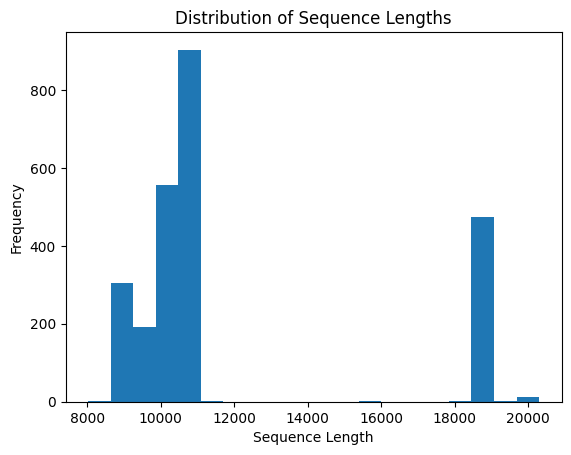


Nucleotide Composition Statistics:
                 A            C            G            T        Other
count  2450.000000  2450.000000  2450.000000  2450.000000  2450.000000
mean   3393.081633  2717.713878  3009.962041  2767.887755    87.611020
std    1401.196116   696.095502   437.560506  1166.573543   384.676748
min    1429.000000  1067.000000  1425.000000  1030.000000     0.000000
25%    2792.250000  2257.000000  2619.000000  2149.000000     0.000000
50%    2999.000000  2475.500000  3069.000000  2276.000000     0.000000
75%    3375.000000  2744.000000  3139.000000  2400.000000     2.000000
max    6367.000000  4434.000000  4151.000000  5350.000000  5706.000000


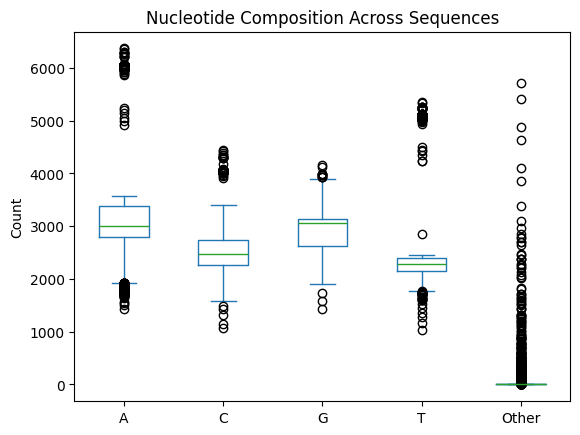


Number of U's in sequences: 0

Sequences with Invalid Characters:
     accession_id       invalid_chars
45     PQ866918.1  {R, S, M, W, K, Y}
55     LC793496.1           {S, K, R}
56     LC793495.1              {Y, R}
57     LC793494.1                 {Y}
66     PP582679.1              {K, Y}
...           ...                 ...
2464   MW862107.1              {Y, R}
2471   MW862100.1                 {R}
2473   MW862098.1              {Y, R}
2478   MW862093.1                 {R}
2483   MW862073.1              {Y, R}

[438 rows x 2 columns]
Final dataset saved as virus_sequences_final_dataset.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load raw data
raw_output_file = "virus_sequences_raw.csv"
if not os.path.exists(raw_output_file):
    raise FileNotFoundError(f"{raw_output_file} not found. Please run the fetching cell first.")
data = pd.read_csv(raw_output_file)

# Function to preprocess sequences
def preprocess_sequences(sequences):
    sequences = [seq.replace("U", "T") for seq in sequences]
    lengths = [len(seq) for seq in sequences]
    valid_idx = [i for i, l in enumerate(lengths) if l >= 7000]
    sequences = [sequences[i] for i in valid_idx]
    lengths = [lengths[i] for i in valid_idx]
    invalid_chars = [set(seq) - set("ACGTN") for seq in sequences]
    sequences = [''.join('N' if c in set("YKWRSMDH") else c for c in seq) for seq in sequences]
    return sequences, lengths, invalid_chars, valid_idx

# Apply preprocessing and filter DataFrame
sequences, lengths, invalid_chars, valid_idx = preprocess_sequences(data["sequence"].tolist())
data = data.iloc[valid_idx].copy()
data["sequence"] = sequences
data["length"] = lengths
data["invalid_chars"] = invalid_chars

# Display dataset stats
print("\nDataset Info:")
print(data.info())
print("\nClass Distribution:")
print(data["species"].value_counts())
print("\nSample Sequence (first 100 bases):")
print(data.iloc[0]["sequence"][:100])

# Sequence length and nucleotide analysis
print("\nSequence Length Statistics:")
print(data["length"].describe())
plt.hist(data["length"], bins=20)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Sequence Lengths")
plt.show()

def count_nucleotides(sequence):
    return {
        "A": sequence.count("A"),
        "C": sequence.count("C"),
        "G": sequence.count("G"),
        "T": sequence.count("T"),
        "Other": len(sequence) - (sequence.count("A") + sequence.count("C") + sequence.count("G") + sequence.count("T"))
    }

nucleotide_counts = data["sequence"].apply(count_nucleotides).apply(pd.Series)
print("\nNucleotide Composition Statistics:")
print(nucleotide_counts.describe())
nucleotide_counts.plot(kind="box")
plt.title("Nucleotide Composition Across Sequences")
plt.ylabel("Count")
plt.show()

print("\nNumber of U's in sequences:", data["sequence"].str.count("U").sum())
print("\nSequences with Invalid Characters:")
print(data[data["invalid_chars"].apply(len) > 0][["accession_id", "invalid_chars"]])

# Save final dataset
final_output_file = "virus_sequences_final_dataset.csv"
data.to_csv(final_output_file, index=False)
print(f"Final dataset saved as {final_output_file}")

# CNN

Number of duplicate sequences: 198
Removed duplicates. New dataset size: 2252
Augmented dataset size: 6756
Loading preprocessed data...

Fold 1/5
Starting training...
Epoch 1/50
19/19 [==============================] - 3s 116ms/step - loss: 2.4406 - accuracy: 0.2246 - val_loss: 2.3182 - val_accuracy: 0.2485 - lr: 0.0010
Epoch 2/50
19/19 [==============================] - 2s 108ms/step - loss: 2.2393 - accuracy: 0.2363 - val_loss: 2.1406 - val_accuracy: 0.2485 - lr: 0.0010
Epoch 3/50
19/19 [==============================] - 2s 108ms/step - loss: 2.0755 - accuracy: 0.2997 - val_loss: 1.9907 - val_accuracy: 0.2530 - lr: 0.0010
Epoch 4/50
19/19 [==============================] - 2s 108ms/step - loss: 1.9237 - accuracy: 0.3426 - val_loss: 1.8162 - val_accuracy: 0.5222 - lr: 0.0010
Epoch 5/50
19/19 [==============================] - 2s 108ms/step - loss: 1.6982 - accuracy: 0.4505 - val_loss: 1.4993 - val_accuracy: 0.5962 - lr: 0.0010
Epoch 6/50
19/19 [==============================] - 2s 109

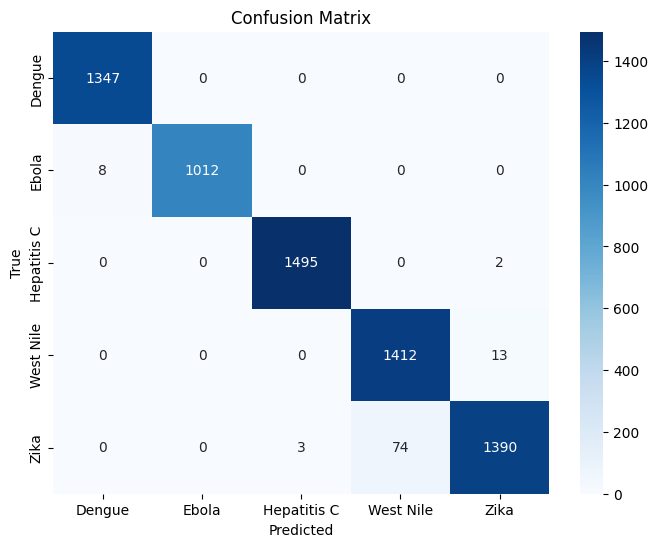

In [ ]:
import pandas as pd
import numpy as np
import os
import gc
import time
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf

# Load the cleaned dataset
data = pd.read_csv("virus_sequences_final_dataset.csv")

# Step 1: Check for duplicates
data["sequence_hash"] = data["sequence"].apply(hash)
duplicate_hashes = data["sequence_hash"].duplicated().sum()
print(f"Number of duplicate sequences: {duplicate_hashes}")
if duplicate_hashes > 0:
    data = data.drop_duplicates(subset="sequence_hash")
    print(f"Removed duplicates. New dataset size: {len(data)}")

# Step 2: Preprocess the sequences
def one_hot_encode(sequence, max_length=7053):
    mapping = {'A': [1, 0, 0, 0, 0], 'C': [0, 1, 0, 0, 0], 'G': [0, 0, 1, 0, 0],
               'T': [0, 0, 0, 1, 0], 'N': [0, 0, 0, 0, 1]}
    if len(sequence) > max_length:
        start = random.randint(0, len(sequence) - max_length)
        sequence = sequence[start:start + max_length]
    else:
        sequence = sequence + 'N' * (max_length - len(sequence))
    encoded = np.array([mapping[base] for base in sequence], dtype=np.float32)
    return encoded

# Step 3: Data augmentation with increased mutation rate
def augment_sequence(sequence, mutation_rate=0.005):
    seq_list = list(sequence)
    for i in range(len(seq_list)):
        if random.random() < mutation_rate:
            seq_list[i] = random.choice(['A', 'C', 'G', 'T'])
    return ''.join(seq_list)

# Apply preprocessing and augmentation
max_length = 7053
augmented_data = []
augmented_labels = []
for _, row in data.iterrows():
    seq = row["sequence"]
    label = row["species"]
    augmented_data.append(seq)
    augmented_labels.append(label)
    for _ in range(2):
        aug_seq = augment_sequence(seq)
        augmented_data.append(aug_seq)
        augmented_labels.append(label)

augmented_df = pd.DataFrame({"sequence": augmented_data, "species": augmented_labels})
print(f"Augmented dataset size: {len(augmented_df)}")

# Precompute and save the preprocessed data
preprocessed_file = "preprocessed_X.npy"
if os.path.exists(preprocessed_file):
    print("Loading preprocessed data...")
    X = np.load(preprocessed_file)
else:
    print("Preprocessing data...")
    X = np.array([one_hot_encode(seq, max_length) for seq in augmented_df["sequence"]])
    np.save(preprocessed_file, X)
    print(f"Saved preprocessed data to {preprocessed_file}")

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(augmented_df["species"])
y = to_categorical(y, dtype='float32')

# Clear memory before proceeding
gc.collect()
tf.keras.backend.clear_session()

# Step 4: 5-fold cross-validation with shuffling for robust splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Shuffle samples for robust cross-validation
fold = 1
test_accuracies = []
all_y_true = []
all_y_pred = []

for train_index, test_index in kf.split(X):
    print(f"\nFold {fold}/5")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

    # Convert to tf.data.Dataset with minimal pipeline
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    # Ensure data is in the right format for GPU
    def to_gpu_format(x, y):
        with tf.device('/GPU:0'):
            return tf.cast(x, tf.float32), tf.cast(y, tf.float32)

    # Simple pipeline: batch, cache, and prefetch, all on GPU
    batch_size = 256  # Increased batch size to maximize GPU usage
    train_dataset = (train_dataset
                     .map(to_gpu_format, num_parallel_calls=tf.data.AUTOTUNE)
                     .batch(batch_size)
                     .cache()  # Cache to reduce CPU overhead
                     .prefetch(tf.data.AUTOTUNE))
    val_dataset = (val_dataset
                   .map(to_gpu_format, num_parallel_calls=tf.data.AUTOTUNE)
                   .batch(batch_size)
                   .cache()
                   .prefetch(tf.data.AUTOTUNE))
    test_dataset = (test_dataset
                    .map(to_gpu_format, num_parallel_calls=tf.data.AUTOTUNE)
                    .batch(batch_size)
                    .cache()
                    .prefetch(tf.data.AUTOTUNE))

    # Step 5: Build the CNN + AdditiveAttention model using the Functional API
    inputs = Input(shape=(max_length, 5))

    # CNN layers with reduced filters and increased regularization
    x = Conv1D(filters=16, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01))(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=32, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=32, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = MaxPooling1D(pool_size=2)(x)  # Sequence length: 440
    x = MaxPooling1D(pool_size=2)(x)  # Sequence length: 220

    # AdditiveAttention
    attention_output = AdditiveAttention()([x, x])  # Pass input as both query and value

    # Remaining layers
    x = tf.keras.layers.GlobalAveragePooling1D()(attention_output)
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(len(label_encoder.classes_), activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    with tf.device('/GPU:0'):
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    # Step 6: Train the model on GPU:0 with manual timing
    with tf.device('/GPU:0'):
        print("Starting training...")
        start_time = time.time()
        history = model.fit(train_dataset, epochs=50,
                            validation_data=val_dataset, callbacks=[lr_scheduler], verbose=1)
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Total training time: {training_time:.2f} seconds")
        print(f"Average time per epoch: {training_time / len(history.epoch):.2f} seconds")

    # Step 7: Evaluate on the test set on GPU:0
    with tf.device('/GPU:0'):
        test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
        print(f"Fold {fold} Test Accuracy: {test_accuracy:.4f}")
        test_accuracies.append(test_accuracy)  # Append test accuracy to the list

        # Debug test predictions
        y_pred = model.predict(test_dataset, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test, axis=1)
        print(f"Test true labels (first 10): {y_test_classes[:10]}")
        print(f"Test predicted labels (first 10): {y_pred_classes[:10]}")
        print(f"Test class distribution: {np.bincount(y_test_classes)}")

        all_y_true.extend(y_test_classes)
        all_y_pred.extend(y_pred_classes)

    fold += 1

    # Clear memory after each fold
    gc.collect()
    tf.keras.backend.clear_session()

# Step 8: Summarize cross-validation results
print(f"\nCross-Validation Test Accuracies: {test_accuracies}")
print(f"Mean Test Accuracy: {np.mean(test_accuracies):.4f} (+/- {np.std(test_accuracies):.4f})")

# Step 9: Confusion Matrix and Classification Report
cm = confusion_matrix(all_y_true, all_y_pred)
print("\nClassification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=label_encoder.classes_))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Experiments


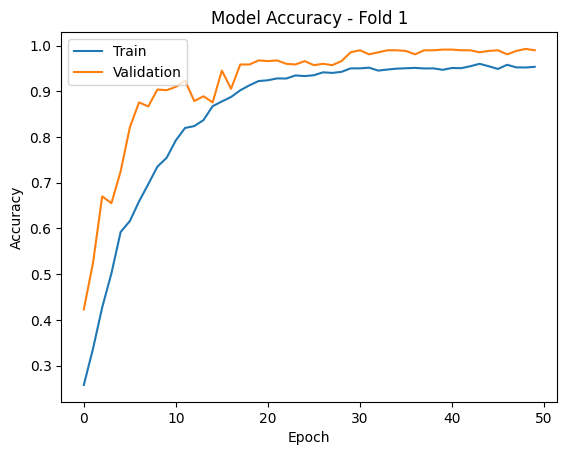

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy - Fold 1')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

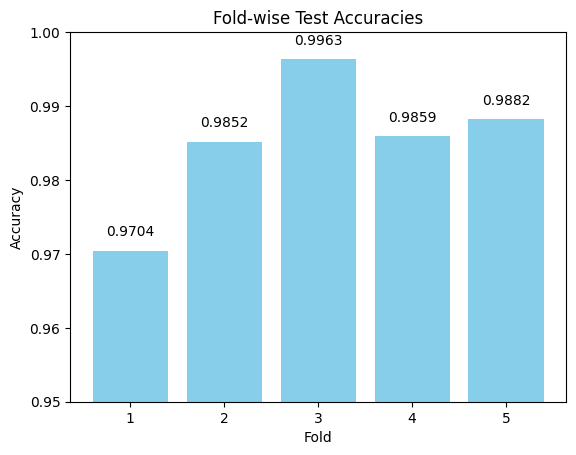

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
folds = np.arange(1, 6)
accuracies = [0.9704, 0.9852, 0.9963, 0.9859, 0.9882]
plt.bar(folds, accuracies, color='skyblue')
plt.title('Fold-wise Test Accuracies')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0.95, 1.0)  # Adjust to focus on high accuracy range
for i, v in enumerate(accuracies):
    plt.text(i + 1, v + 0.002, f'{v:.4f}', ha='center')
plt.show()

In [ ]:
import pandas as pd
csv_data = pd.read_csv('virus_sequences_preprocessed_with_influenza_cleaned.csv')
print(csv_data.head())  # View first 5 rows
print(csv_data.columns)  # List columns
print(csv_data.shape)    # Rows and columns

  accession_id                                           sequence     species  \
0   PV412562.1  ACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATC...  SARS-CoV-2   
1   PV412561.1  ACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATC...  SARS-CoV-2   
2   PV412557.1  AACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAAT...  SARS-CoV-2   
3   PV412554.1  ACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATC...  SARS-CoV-2   
4   PV412553.1  ACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATC...  SARS-CoV-2   

   length invalid_chars  
0   29750         set()  
1   29747         set()  
2   29746         set()  
3   29737         set()  
4   29746         set()  
Index(['accession_id', 'sequence', 'species', 'length', 'invalid_chars'], dtype='object')
(500, 5)


In [ ]:
duplicates = data.duplicated(subset=["sequence"], keep=False)
print(data[duplicates])


In [ ]:
import matplotlib.pyplot as plt

# Extract accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Random Forest

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Function to generate k-mers
def get_kmers(sequence, k=3):
    return " ".join([sequence[i:i+k] for i in range(len(sequence) - k + 1)])

# Apply k-mer encoding
k = 3  # Use 3-mers
data["kmers"] = data["sequence"].apply(lambda x: get_kmers(x, k))

# Convert k-mers to numerical features
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["kmers"]).toarray()

# Encode labels (species)
species_to_label = {species: idx for idx, species in enumerate(data["species"].unique())}
y = data["species"].map(species_to_label).values

# Print feature matrix shape
print("Feature Matrix Shape:", X.shape)
print("Labels Shape:", y.shape)
print("Label Mapping:", species_to_label)

# Split the data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify the class distribution in the test set
print("\nClass Distribution in Test Set:")
unique, counts = np.unique(y_test, return_counts=True)
test_distribution = dict(zip([list(species_to_label.keys())[i] for i in unique], counts))
print(test_distribution)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("\nRandom Forest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=list(species_to_label.keys())))

# Feature importance (top 10 k-mers)
feature_importance = pd.DataFrame({
    "kmer": vectorizer.get_feature_names_out(),
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)
print("\nTop 10 Most Important k-mers:")
print(feature_importance.head(10))